In [443]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,20)

In [444]:
data = pd.read_csv('wiki_links.csv')

In [445]:
data.shape

(164470, 2)

In [446]:
data.head()

,source,destination
0,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Earl_of_Desart
1,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/File:Earl_of_Dys...
2,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Charles_I_of_Eng...
3,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Peerage_of_Scotland
4,https://en.wikipedia.org/wiki/Earl_of_Dysart,"https://en.wikipedia.org/wiki/William_Murray,_..."


1. Can we determine clusters in the data (This will help in getting related articles).
2. Can we create a generator for article title.

In [447]:
data['source title'] = data['source'].apply(lambda x: 
                                            x.replace(':','/').split('/')[-1]\
                                            .replace('_',' '))
data['destination title'] = data['destination'].apply(lambda x: x.split('/')[-1]\
                                                      .replace('_',' '))

In [448]:
data.head()

,source,destination,source title,destination title
0,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Earl_of_Desart,Earl of Dysart,Earl of Desart
1,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/File:Earl_of_Dys...,Earl of Dysart,File:Earl of Dysart COA.svg
2,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Charles_I_of_Eng...,Earl of Dysart,Charles I of England
3,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Peerage_of_Scotland,Earl of Dysart,Peerage of Scotland
4,https://en.wikipedia.org/wiki/Earl_of_Dysart,"https://en.wikipedia.org/wiki/William_Murray,_...",Earl of Dysart,"William Murray, 1st Earl of Dysart"


In [449]:
len(data['source'].unique())

558

In [450]:
len(data['destination'].unique())

94707

### create the network

In [451]:
df = data.drop(['source', 'destination'], axis=1)

### trimming excess leaves

In [452]:
sources = list(df['source title'].unique())
len(sources)

541

In [453]:
df['keep'] = df['destination title'].apply(lambda x: 
                                           True if x in
                                           sources else False)

In [454]:
df = df[df['keep']].drop('keep', axis=1)

In [455]:
from sklearn import preprocessing
se = preprocessing.LabelEncoder()
se.fit(df['source title'])
df['source label'] = se.transform(df['source title'])
de = preprocessing.LabelEncoder()
de.fit(df['destination title'])
df['destination label'] = de.transform(df['destination title'])

In [456]:
df.head()

,source title,destination title,source label,destination label
0,Earl of Dysart,Earl of Desart,126,100
2,Earl of Dysart,Charles I of England,126,69
3,Earl of Dysart,Peerage of Scotland,126,251
4,Earl of Dysart,"William Murray, 1st Earl of Dysart",126,374
5,Earl of Dysart,"John Grant, 13th Earl of Dysart",126,170


In [457]:
n_df = df.drop(['source title', 'destination title'], axis=1)

In [458]:
records = list(n_df.to_records(index=False))
records = [i for i in records if i[0]!=i[1]]

In [459]:
G = nx.Graph()
G.add_edges_from(records)

In [460]:
G.number_of_nodes()

475

In [461]:
G.number_of_edges()

2809

In [462]:
len(list(nx.connected_components(G)))

1

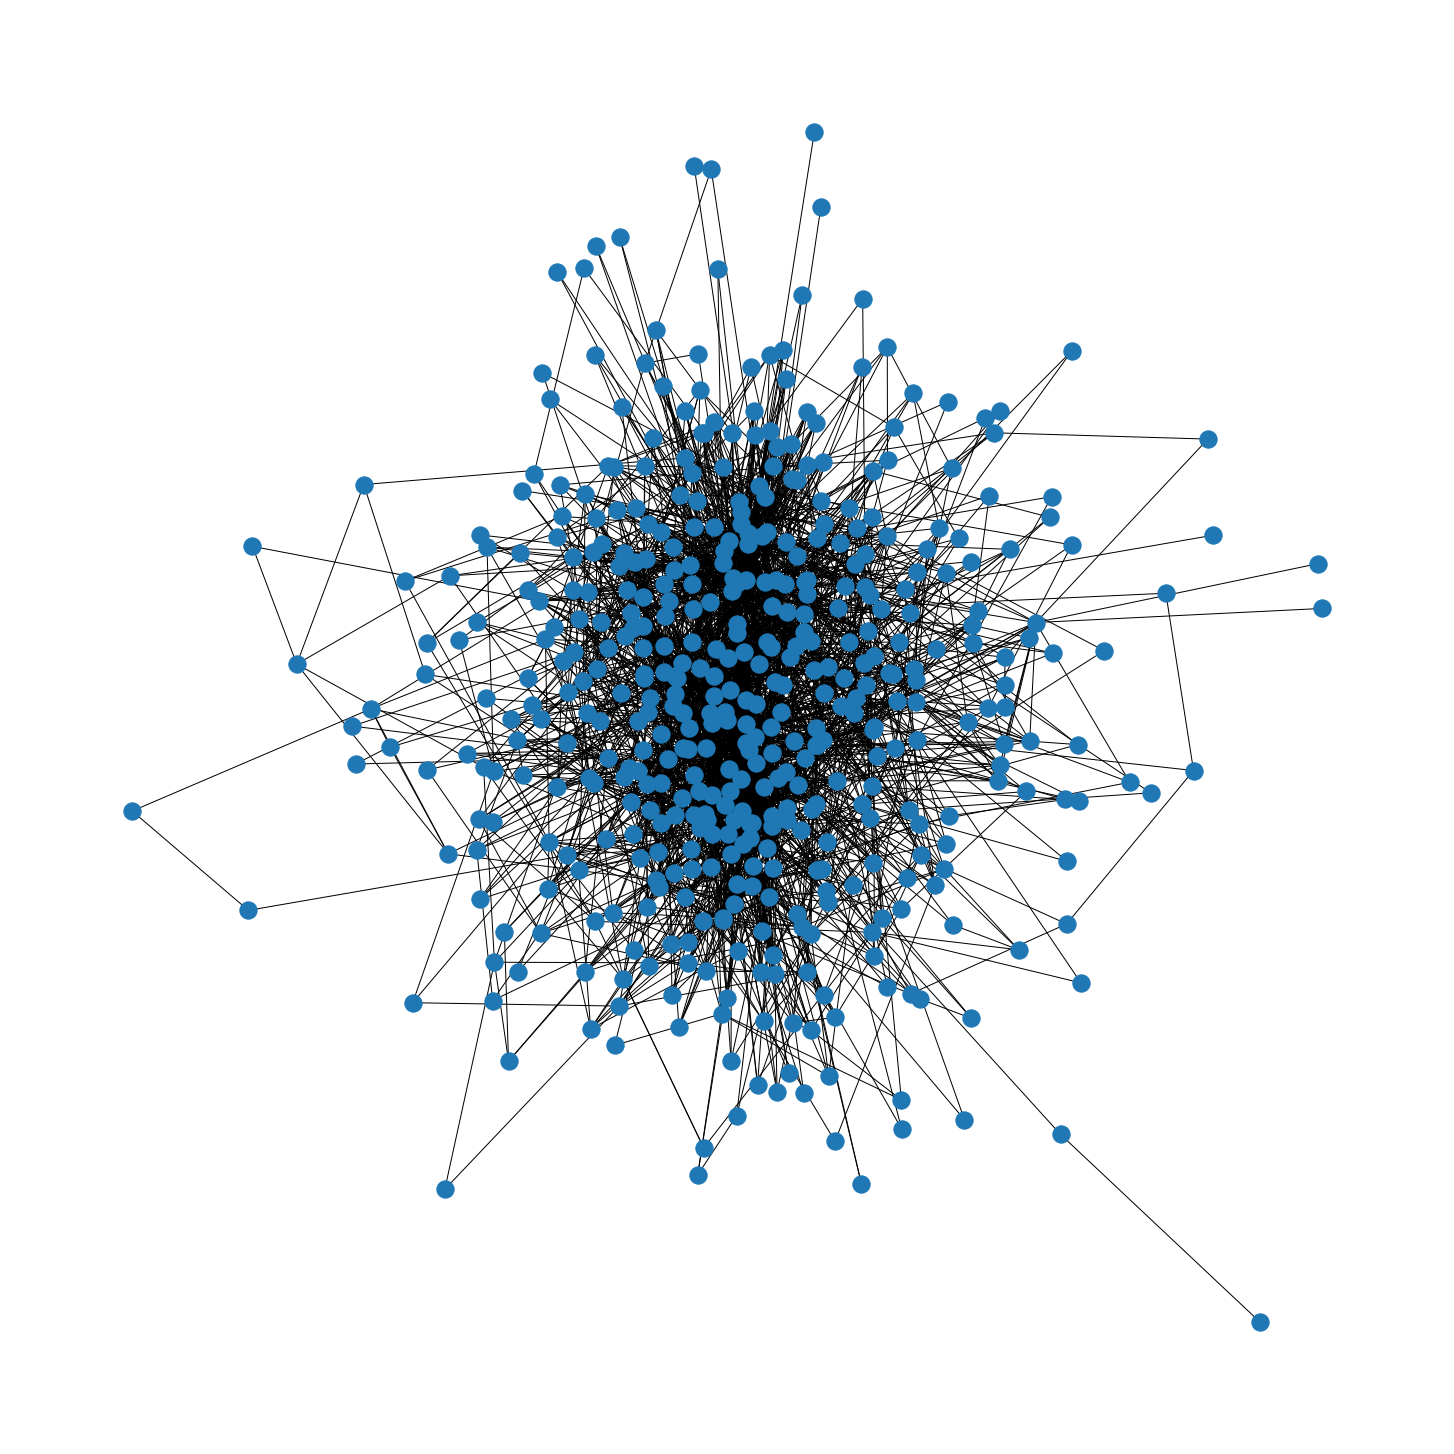

In [463]:
nx.draw(G)

In [464]:
from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(G, dimensions=2, walk_length=20, 
                    num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


In [465]:
from sklearn.cluster import KMeans
import numpy as np
X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
#print(X)
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z
#print(Z)
kmeans = KMeans(n_clusters=5, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

[0 4 0 3 3 3 3 3 3 1 0 0 3 3 1 0 3 0 3 0 3 0 0 0 0 1 1 1 4 0 1 1 0 1 0 0 3
 1 3 3 4 0 1 4 0 4 1 1 1 1 1 1 0 1 1 0 4 0 4 0 1 1 4 0 0 0 0 4 4 4 3 3 0 1
 1 4 4 4 4 3 0 0 1 1 0 1 0 4 4 1 4 4 4 4 1 1 0 4 0 4 4 0 1 0 0 1 0 4 0 4 4
 0 4 4 4 1 4 0 0 4 4 4 3 4 1 1 0 1 1 4 4 4 1 1 4 1 0 4 1 0 0 4 0 4 0 1 3 0
 1 4 1 4 4 1 1 4 4 4 4 4 4 4 1 4 4 1 4 0 0 4 1 1 0 4 0 1 0 4 0 0 4 1 1 1 0
 0 1 0 0 1 0 1 4 1 1 4 4 4 0 4 3 0 0 0 1 1 1 1 1 1 0 4 1 1 0 4 4 4 0 1 0 0
 0 0 4 0 1 0 1 0 4 4 4 4 4 1 1 4 0 0 1 0 1 0 3 4 4 0 1 0 1 1 0 4 0 3 1 1 0
 0 0 1 4 4 4 4 4 0 1 4 4 0 0 4 4 0 1 4 4 4 3 1 0 0 1 0 1 1 0 0 1 0 0 0 0 3
 0 1 0 1 0 0 1 4 4 4 4 4 4 4 0 0 0 4 1 4 4 1 0 0 1 0 0 1 0 0 0 1 1 3 3 1 3
 1 1 1 1 1 0 4 1 1 4 1 0 0 4 1 4 3 0 3 1 0 3 1 4 1 1 4 1 4 2 4 0 1 1 1 1 0
 1 1 0 1 4 0 4 4 0 1 4 1 1 4 0 0 0 1 3 3 3 3 4 4 1 4 3 3 3 3 3 4 0 1 4 3 1
 0 4 0 3 1 1 3 3 3 3 0 0 3 3 0 0 1 1 1 1 1 1 0 4 1 1 0 3 0 0 0 2 0 3 0 3 0
 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 4 4 4 4 4 4 0 4 4 0 3 0]


In [466]:
result = pd.DataFrame(X)

In [467]:
result[3] = labels

In [468]:
result.columns = ['source label', 'axis 1', 'axis 2', 'cluster']
result = result.drop(['axis 1', 'axis 2'],axis=1)

In [469]:
result.head()

,source label,cluster
0,0.0,0
1,1.0,4
2,2.0,0
3,3.0,3
4,4.0,3


In [470]:
df = pd.merge(df, result, on='source label', how='left')

In [471]:
df.head()

,source title,destination title,source label,destination label,cluster
0,Earl of Dysart,Earl of Desart,126,100,0
1,Earl of Dysart,Charles I of England,126,69,0
2,Earl of Dysart,Peerage of Scotland,126,251,0
3,Earl of Dysart,"William Murray, 1st Earl of Dysart",126,374,0
4,Earl of Dysart,"John Grant, 13th Earl of Dysart",126,170,0


In [472]:
data.head()

,source,destination,source title,destination title
0,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Earl_of_Desart,Earl of Dysart,Earl of Desart
1,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/File:Earl_of_Dys...,Earl of Dysart,File:Earl of Dysart COA.svg
2,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Charles_I_of_Eng...,Earl of Dysart,Charles I of England
3,https://en.wikipedia.org/wiki/Earl_of_Dysart,https://en.wikipedia.org/wiki/Peerage_of_Scotland,Earl of Dysart,Peerage of Scotland
4,https://en.wikipedia.org/wiki/Earl_of_Dysart,"https://en.wikipedia.org/wiki/William_Murray,_...",Earl of Dysart,"William Murray, 1st Earl of Dysart"


In [473]:
final = pd.merge(data, df, on='source title', how='inner' )\
.drop(['destination', 'destination title_x','destination title_y', 'destination label'], axis=1)

In [474]:
final = final.drop_duplicates()

In [475]:
final.shape

(491, 4)

In [476]:
final

,source,source title,source label,cluster
0,https://en.wikipedia.org/wiki/Earl_of_Dysart,Earl of Dysart,126,0
10065,https://en.wikipedia.org/wiki/Earl_of_Desart,Earl of Desart,125,1
10109,https://en.wikipedia.org/wiki/File:Earl_of_Dys...,Earl of Dysart COA.svg,127,1
10131,https://en.wikipedia.org/wiki/Charles_I_of_Eng...,Charles I of England,78,4
12615,https://en.wikipedia.org/wiki/Peerage_of_Scotland,Peerage of Scotland,292,0
...,...,...,...,...
1416805,https://en.wikipedia.org/wiki/Wikipedia:User_p...,User pages#What may I not have in my user pages?,407,0
1419979,https://en.wikipedia.org/wiki/Wikipedia:What_v...,What vandalism is not,429,0
1421163,https://en.wikipedia.org/wiki/Wikipedia:Disamb...,Disambiguation#What not to include,120,4
1425339,https://en.wikipedia.org/wiki/Wikipedia:No_ori...,No original research,259,0
